# Fama 3 factor model in A-share market
Author: Mingshi Wu, Andy Huang

Date: 08-08-2017

In [8]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

### Introduction
The Capital Asset Pricing Model(CAPM), which was introduced by William Sharpe et.al(1964), provides a solid fundation for modern financial marketing. CAPM put forward that in perfect market, any portfolio's excess return ($\alpha$) is proportional to market's risk premium, where:

<br />

<center>
<font size = 3>
$E(\tilde{r_l}) - r_F = \beta_i * E(\tilde{r_M}- r_F) + \epsilon _i$
</font>
<font size = 1>

$E(\tilde{r_l})\text{: the expected return on asset i}$

$r_F\text{: the risk free rate}$

$E(\tilde{r_M}) \text{: the expected return of the market}$

$\epsilon_i \text{: regression residual}$

$\beta_i= Cov(\tilde{r_l},\tilde{r_M})/Var(\tilde{r_M})$
</font>
</center >
<br />

In the formula, $E(\tilde{r_M} - r_F)$ is the market premium, and $\beta_i * E(\tilde{r_M}- r_F)$ is called risk premium. In other words, theoretically, the excess return can be explained by a common factor ($\alpha$ should be zero), $\beta_i$. However, the market is not perfect in the reality, $\beta_i$ can not fully explain the excess return ($\alpha$ is not zero). So Fama and French (1992) found that two kind of stocks have tended to do better than the market as a whole: one is small caps and the other is the stocks with a high Book-to-market ratio (B/P). And the formula is as follow:
  
<br />
<center>
<font size = 3>
$R_{it} - R_{ft} = \alpha_i + \beta_i(R_{Mt} - R_{Ft} ) + s_iSMB_t +h_iHML_t + \epsilon_{it}$
</font>
<font size = 1>

$R_{it}:\text{The rate of return of asset i in t moment}$

$R_{Ft}:\text{the risk free rate in t moment}$

$R_{Mt}:\text{The rate of return of the market in t moment}$

$R_{Mt} - R_{Ft}: \text{The market premium in t moment}$

$SMB_t:\text{Small market capitalization minus big market capitalization}$

$HML_t:\text{High B/P minus low B/P}$

$\alpha_t,\beta_t,s_i,h_i :\text{Corresponding coefficients}$

$\epsilon_{it}:\text{Regression residual }$

</font>
</center >
<br />
In the following sections, we will test the application of Fama and French Three Factors Model in A-shares market in China.

### Data

##### overall

We extract all A-shares stocks from Oracle database. The raw data is from 05-01-2011 to 06-30-2016. Informations we need to use are trade day, stock code, adjusted closing price, circulation market value  and P/B ratio. We also drop all special treatment (ST) stock, suspended trading stock those stocks which are less than 1 year. We take the risk free rate as 2%. In addition, we use CSI 300 Index to be our benchmark.

##### Details
1. The data we extract from the database is daily trading data, but what we need is monthly data. So we do the following steps to get monthly data from daily data.
    1. Get daily data from Oracle, and transform to int format， so the first two digit is the date. (e.g. if we have 20110530, 
    then 30 represent the date

    2. store the original dates in array A, then shift down to get the lagged dates and store in array B. 
    
    3. Use array A minus array B, if positive, then return the dates, which are the end of the months.

    P.S. If we shift down, the last date (06-30-2016) will become NaN, so I will fill it as 0 so that my algorithm still be true 
    for the last day.  
2. We get BE/ME by calculating the reciprocal of P/B ratio (1/PB).
3. We use circulation market value to measure companies' size.
4. If one's closing price is NaN, we will fill it with the latest closing price

In [ ]:
import cx_Oracle as ora
import pandas as pd
import pickle
import numpy as np
import statsmodels.api as sm
from scipy import stats
import matplotlib.pyplot as plt

# Risk free rate
rf = 0.02

def GetDataFromOracle(sql):
    # Connecting to Oracle database
    conn = ora.connect("query01", "query01","10.1.1.10:1521/orclly")
    cursor = conn.cursor()
    table = cursor.execute(sql)

    # Save as Dataframe
    df_table = pd.DataFrame(list(table))
    columns = pd.DataFrame(list(table.description))
    df_table.columns = columns[0]
    cursor.close()
    conn.close()

    return df_table

sql1 = "select a.trade_dt, a.s_info_windcode, a.s_dq_adjclose, \
           b.s_dq_mv, b.s_val_pb_new \
       from lyzs_wind.WIN_ASHAREEODPRICES a \
       left join lyzs_wind.Win_a_Sh_Eo_De_Ind b  \
            on a.s_info_windcode = b.s_info_windcode \
               and a.trade_dt = b.trade_dt \
       left join lyzs_wind.TB_STOCK_DATA_TRADE_DAY c \
            on a.s_info_windcode = c.S_INFO_WINDCODE \
               and a.trade_dt = c.TRADE_DT \
       where a.trade_dt between  20110501 and 20160630  \
             and c.S_DQ_TRADESTATUS  in ('XR', 'TD', 'XD', 'DR') \
             and c.is_st = 0 \
             and (c.TRADE_DT - c.S_INFO_LISTDATE) > 10000 \
        order by a.trade_dt, a.s_info_windcode"

# I use the same database as the one I used in FF_three_factor program

# raw_base = GetDataFromOracle(sql1)
# pickle.dump(raw_base,open("FF_three_factor.dat", "wb"),True)
raw_base = pickle.load(open("FF_three_factor.dat","rb"))

# Set index as TRADE_DT
raw_base.index = raw_base['TRADE_DT']

# Get CSI 300 Index

sql2 = "select TRADE_DT, S_DQ_CLOSE from lyzs_wind.WIN_HS300IEODPRICES \
                    where TRADE_DT between 20110630 and 20160630 \
                    order by TRADE_DT"

# raw_base_benchmark = GetDataFromOracle(sql2)
# pickle.dump(raw_base_benchmark,open("300_benchmark.dat","wb"),True)
raw_base_benchmark = pickle.load(open("300_benchmark.dat","rb"))
raw_base_benchmark.index = raw_base_benchmark['TRADE_DT']

def get_monthly_end_factor_data_from_daily_data(factor_data):

    monthly_end_close_data = \
        factor_data.loc[factor_data.index[
            np.mod(pd.Series(factor_data.index).astype(int), 100).sub(
                np.mod(pd.Series(factor_data.index).shift(-1).fillna(0).astype(int), 100), axis=0) > 0]]
    return monthly_end_close_data


monthly_data = get_monthly_enmonthly_data = get_monthly_end_factor_data_from_daily_data(raw_base)
# Drop those data whose P/B are negative
monthly_data = monthly_data[monthly_data.S_VAL_PB_NEW > 0].dropna()
# Get BP
monthly_data['S_VAL_PB_NEW'] = 1/monthly_data['S_VAL_PB_NEW']
# Get all stocks' closing price
monthly_close = pd.DataFrame(monthly_data.pivot(values = 'S_DQ_ADJCLOSE', index = 'TRADE_DT', columns = 'S_INFO_WINDCODE'))
# Fill the empty as the previous closing price
monthly_close = monthly_close.fillna(method='pad')
# Get the monthly log return rate
R_month = pd.DataFrame(np.log(monthly_close.div(monthly_close.shift(1))))

def TransformDataStructor(factor, factorname):
    df = pd.DataFrame(columns = [factorname, 'S_INFO_WINDCODE', 'TRADE_DT'])
    for date in factor.index:
        df_tmp = pd.DataFrame(factor.loc[date])
        df_tmp.columns = [factorname]
        df_tmp['S_INFO_WINDCODE'] = df_tmp.index
        df_tmp['TRADE_DT'] = date
        df = df.append(df_tmp, ignore_index = True)
    return df

df_R_month = TransformDataStructor(R_month, 'return_monthly')

# Merge table
monthly_data = pd.merge(monthly_data, df_R_month, how= 'left', on =['S_INFO_WINDCODE', 'TRADE_DT'])
# Change index to TRADE_DT
monthly_data.index = monthly_data['TRADE_DT']
# Delete the first month (we don't need it)
monthly_data = monthly_data.drop([monthly_data.index[0]])
# Drop NaN
monthly_data = monthly_data.dropna()

# Get CSI 300 Index
monthly_data_benchmark = get_monthly_end_factor_data_from_daily_data(raw_base_benchmark)
del monthly_data_benchmark['TRADE_DT'] # delete trade-dt
R_monthly_benchmark = pd.DataFrame(np.log(monthly_data_benchmark.div(monthly_data_benchmark.shift(1)))) # Calculate log return
R_monthly_benchmark = R_monthly_benchmark.drop(R_monthly_benchmark.index[0]) # Delete first month
each_month = list(monthly_data[['S_INFO_WINDCODE','S_DQ_MV','return_monthly']].groupby(monthly_data['TRADE_DT']))

### Explanatory variable

##### Overrall

Fama and French (1993) came up with three factors to be explanatory variables: Market factor, size factor and BE/ME factor. So we need to build up these factors one by one. First, all stocks are sorted by market value by the end of June each year, and we use these data as a standard to divide the follwing year data by 50 percentile, into S (small group) and B (big group). (e.g. If we use 06-2011 as a standard, then we divide the data from 07-01-2011 to 06-31-2012 using the same standard). Meanwhile, we sorted the data by BE/ME by the end of June each year, and divide into L(Low, 30%), M (Medium, 40%) and H (High, 70%). Then we take the intersection of (S, B) and (H, M, L ) to get 6 combination: SL, SM, SH, BL, BM, BH. Finally, we calculate SMB and HML by:

<br />
<center>
<font size = 3>
$SMB(t) = \frac{SL(t)+SM(t)+SH(t)}{3} - \frac{BL(t)+BM(t)+BH(t)}{3}$
</font>
</center>

<br />
<center> 
<font size = 3>       
$HML(t) = \frac{SH(t)+BH(t)}{2} - \frac{SL(t)+BL(t)}{2}$
</font>
</center>
<br />

and calculate corresponding market factor by:

<br />
<center>
<font size = 3>
$R_m - R_f = \text{CSI 300 Index closing price } - ln(\frac{R_f}{12} + 1)$
</font>
</center>
<br />

In [ ]:
# Grouping
def grouping(year):
    if (str(year) + '0630') in monthly_data.index:
        k = str(year) + '0630'
    elif (str(year) + '0629') in monthly_data.index:
        k = str(year) + '0629'
    else:
        k = str(year) + '0628'
    # If the end of the month is not trading date(weekend), it would be at most 2 day

    june = monthly_data.loc[k] # Get June data
    june.index = june.S_INFO_WINDCODE

    mv_50_percentile = np.percentile(june['S_DQ_MV'],50) # market value 50 percentile
    S = june[june.S_DQ_MV < mv_50_percentile].index.tolist()
    B = june[june.S_DQ_MV > mv_50_percentile].index.tolist()

    BP_30_percentile = np.percentile(june['S_VAL_PB_NEW'],30) # BE/ME 30 percentile
    BP_70_percentile = np.percentile(june['S_VAL_PB_NEW'], 70) # BE/ME 70 percentile
    L = june[june.S_VAL_PB_NEW < BP_30_percentile].index.tolist()
    H = june[june.S_VAL_PB_NEW > BP_70_percentile].index.tolist()
    M = list(set(june.S_INFO_WINDCODE.tolist()).difference(set(L + H)))

    # Intersection
    SL = list(set(S).intersection(set(L)))
    SM = list(set(S).intersection(set(M)))
    SH = list(set(S).intersection(set(H)))
    BL = list(set(B).intersection(set(L)))
    BM = list(set(B).intersection(set(M)))
    BH = list(set(B).intersection(set(H)))

    return SL, SM, SH, BL, BM, BH

def get_weighted_return(one_monthly_data, group):
    group_return = one_monthly_data.loc[group]
    group_return = group_return.dropna()
    group_return['weight'] = group_return['S_DQ_MV'] / (group_return['S_DQ_MV'].sum()) # Calculate weight
    group_return['wreturn'] = group_return['return_monthly'] * group_return['weight']
    # Calculate weighted return
    return group_return['wreturn'].sum()

# Get Rm - Rf, SMB and HML
# Get Rm - Rf
R_market_factor = R_monthly_benchmark['S_DQ_CLOSE'].sub(np.log(1 + rf/12)).tolist()

year = [2011,2012,2013,2014,2015]
R_SMB = [] # SMB
R_HML = [] # HML

for i in range(5):
    SL, SM, SH, BL, BM, BH = grouping(year[i])
    for j in range(1,13): # 12 month
        one_monthly_data = each_month[i * 12 + j][1] # i year, j month


        one_monthly_data.index = one_monthly_data['S_INFO_WINDCODE']

        # Calculate each groups weighted return
        
        R_SL = get_weighted_return(one_monthly_data,SL)
        R_SM = get_weighted_return(one_monthly_data,SM)
        R_SH = get_weighted_return(one_monthly_data, SH)
        R_BL = get_weighted_return(one_monthly_data, BL)
        R_BM = get_weighted_return(one_monthly_data, BM)
        R_BH = get_weighted_return(one_monthly_data, BH)

        # Calculate SMB,HML
        SMB = (R_SL + R_SM + R_SH)/3 - (R_BL + R_BM + R_BH)/3
        HML = (R_BH + R_SH)/2 - (R_BL + R_SL)/2

        R_SMB.append(SMB)
        R_HML.append(HML)


#### Testing factor

##### Plot

In [ ]:
# plot
check_factor = pd.DataFrame([R_market_factor,R_SMB,R_HML],index = ['R_market_factor','R_SMB','R_HML']).T
check_factor.index = R_month.index[2::].tolist()
check_factor.cumsum().plot()
plt.xlabel('time')
plt.ylabel('return')
plt.show()

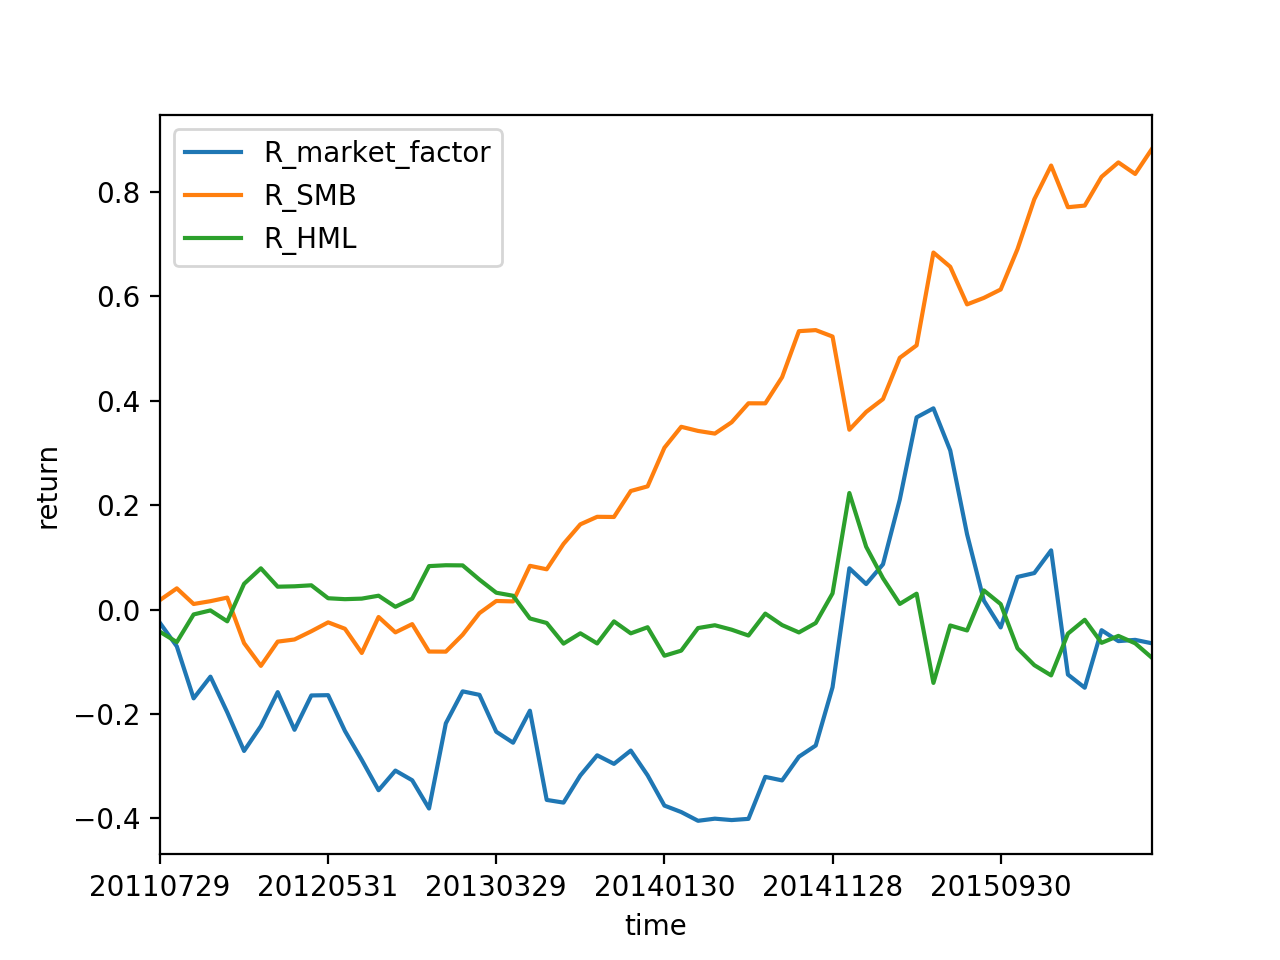

In [3]:
from IPython.display import Image
Image(filename='Figure1.jpg') 

From the plot we can see that the trend of SMB line is increasing, which is empirically reasonable according to the history.

##### Table

In [ ]:
# Factor description
print('Factor description')
print(check_factor.describe())

print('factor correlation coefficient')
check_factor.corr() # factor correlation coefficient

###### Factor Description
|Description| R_market_factor | R_SMB | R_HML|
|------|------|------|------|
|count | 60.000000 | 60.000000 | 60.000000|
|mean | -0.001075 | 0.014712 | -0.001538|
|std | 0.080740 | 0.051504 | 0.051749|
|min | -0.237864 | -0.178497 | -0.170947|
|25% | -0.052131 | -0.005477 | -0.025367|
|50% | -0.005872 | 0.015940 |-0.007151|
|75% | 0.043941 |0.042671 | 0.018438|
|max | 0.227918 | 0.177709 | 0.192301|

###### Factor Correlation Coefficient
| Correlation| R_market_factor | R_SMB | R_HML
---|---|---|---
R_market_factor	|1.000000	|0.161269	|-0.047968
R_SMB|	0.161269|	1.000000|	-0.782976
R_HML|	-0.047968|	-0.782976|	1.000000

From the *Factor Correlation Coefficient table*, we can see that the all correlation are low, which shows that multicollinearity does not exist.

### Explained variable
##### Stratification
Based on market value and BE/ME, we use the data in June each year as a standard to divide the follwing year data into 5 groups (20%,40%,60%,80%), then take intersection to get 25 groups, then take regression.

###### grouping


In [ ]:
# Grouping, 25 groups
def get_25_group(year):
    if (str(year) + '0630') in monthly_data.index:
        k = str(year) + '0630'
    elif (str(year) + '0629') in monthly_data.index:
        k = str(year) + '0629'
    else:
        k = str(year) + '0628'
    # If the end of the month is not trading day, it would be at most 2 days (weekend). 

    june = monthly_data.loc[k] # Get June Data
    june.index = june.S_INFO_WINDCODE

    MV_percentile = np.zeros(6) 
    MV_5 = pd.DataFrame()

    BP_percentile = np.zeros(6) 
    BP_5 = pd.DataFrame()

    for i in range(5):
        # Calculate MV and BP
        MV_percentile[i + 1] = np.percentile(june['S_DQ_MV'],(i+1)*20)
        BP_percentile[i + 1] = np.percentile(june['S_VAL_PB_NEW'], (i + 1) * 20)
        temp1 = june[(june.S_DQ_MV > MV_percentile[i]) & (june.S_DQ_MV <= MV_percentile[i+1])].index.tolist() 
        # save MV in dataframe and merge the table
        MV_5 = pd.concat([MV_5,pd.Series(temp1)],axis= 1) 


        temp2 = june[(june.S_VAL_PB_NEW > BP_percentile[i]) & (june.S_VAL_PB_NEW <= BP_percentile[i+1])].index.tolist() 
        BP_5 = pd.concat([BP_5,pd.Series(temp2)],axis= 1)

    # Drop NaN
    MV_5 = MV_5.dropna()
    BP_5 = BP_5.dropna()

    MV_5.columns = range(5)
    BP_5.columns = range(5)

    group_25 =pd.DataFrame()

    for i in range(5):
        for j in range(5):
            s1 = MV_5[i].tolist()
            s2 = BP_5[j].tolist()
            stocks = pd.Series(list(set(s1).intersection(set(s2)))) # Intersection
            group_25 = pd.concat([group_25, stocks], axis=1)
            # From left to right S1B1,S1B2,..,S1B5,S2B1,...,S2B5,...,S5B1,...,S5B5

    group_25.columns = range(25)

    return group_25
    

###### Calculate the average number of companies of the 25 groups


In [ ]:
number = np.zeros((25,5)) # 25 groups, 5 years
for i in range(5):
    group25 = get_25_group(year[i])
    for j in range(25):
        number[j,i] = len(group25[j].dropna())

number = pd.DataFrame(number)
number_mean = np.array( number.mean(axis = 1), dtype= np.float64).reshape((5,5))
number_mean = pd.DataFrame(number_mean, index = ['Small','2','3','4','Big'], columns= ['low','2','3','4','High'])

print(number_mean)

###### Average number of companies:

|Avg num of companies|Low	| 2	|3	|4	|High
---|---|---|---|---|----
Small|	60.2|	90.8|	97.8|	101.4|	49.4
2|	79.2|	86.0|	91.4|	80.8|	62.4
3|	82.0|	82.2|	75.6|	80.0|	80.0
4|	87.0|	82.6|	74.6|	68.6|	87.2
Big	|91.6|	58.4|	60.0|	68.4|	120.4

In [ ]:
# Get the average of market value in 25 groups
mean_marketvalue = np.zeros((25,12*5))

for i in range(5):
    Group25 = get_25_group(year[i])
    for j in range(1,13):
        one_month = each_month[i * 12 + j][1]
        one_month.index = one_month['S_INFO_WINDCODE']
        for k in range(25):
            group = one_month.loc[Group25[k].dropna()] 
            group = group.dropna()
            mean_marketvalue[k, i * 12 + (j-1)] = group['S_DQ_MV'].mean()

mean_marketvalue = np.mean(mean_marketvalue, axis = 1)
mean_marketvalue = mean_marketvalue.reshape((5,5))
mean_marketvalue = pd.DataFrame(mean_marketvalue, index = ['Small','2','3','4','Big'], columns = ['Low','2','3','4','High'])

print(mean_marketvalue)

###### Mean Market Value

|Mean Market Value|Low	| 2	|3	|4	|High
---|---|---|---|---|----
Small|	1.900671e+05|	1.864214e+05|	1.805863e+05|	1.809572e+05|	2.052265e+05
2|	2.865706e+05|	2.937465e+05|	2.839286e+05|	2.808572e+05|	2.925554e+05
3|	4.474713e+05|	4.182486e+05|	4.161732e+05|	4.057944e+05|	4.166486e+05
4|	6.650765e+05|	6.761773e+05|	6.883083e+05|	6.789911e+05|	7.071824e+05
Big	|2.139797e+06| 2.042950e+06	|2.384223e+06|	3.565393e+06|	7.541950e+06

From the table we can see that the value is increasing from small market value to big market value, and also increasing from low BE/ME to high BE/ME, which shows that our grouping is reasonable.

###### Calculate the excess log return of 25 groups


In [ ]:
E_return = np.zeros((25,12*5))

for i in range(5):
    Group25 = get_25_group(year[i])
    for j in range(1,13):
        one_month = each_month[i*12 + j][1] # i year j month
        one_month.index = one_month['S_INFO_WINDCODE']
        for k in range(25):
            E_return[k,i*12 + (j - 1)] = get_weighted_return(one_month,Group25[k].dropna()) - np.log(1 + rf/12)

# excess log return
E_return_mean = np.mean(E_return, axis = 1)
E_return_mean = E_return_mean.reshape((5,5))
E_return_mean = pd.DataFrame(E_return_mean, index = ['Small', '2', '3', '4', 'Big'], columns= ['Low', '2','3','4','High'])

print('Excess log return of 25 groups')
print(E_return_mean)


###### Excess log return of 25 groups

|log return|Low	| 2	|3	|4	|High
---|---|---|---|---|----
Small|	0.025041|	0.030337|	0.028521|	0.027935|	0.020570
2	|0.015691|	0.022560|	0.017497|	0.018126|	0.014228
3	|0.015432|	0.015291|	0.014217|	0.012668|	0.011299
4	|0.013107|	0.010807|	0.012687|	0.007821|	0.007540
Big	|0.003035|	0.000336|	0.000394|	0.001099|	0.004604

###### Calculate the standard deviation of return of 25 groups


In [ ]:
# the std of return
E_return_std= np.std(E_return, axis= 1)
E_return_std = E_return_std.reshape((5,5))
E_return_std = pd.DataFrame(E_return_std,index = ['Small', '2', '3', '4', 'Big'], columns= ['Low', '2','3','4','High'])

print('The standard deviation of the return')
print(E_return_std)

|std|Low	| 2	|3	|4	|High
---|---|---|---|---|----
Small|	0.124080|	0.129379|	0.121146|	0.115371|	0.106295
2|	0.129408|	0.119055|	0.117234|	0.108807|	0.108189
3|	0.119323|	0.113175|	0.108390|	0.106981|	0.100238
4|	0.116683|	0.107719|	0.106594|	0.103226|	0.095020
Big	|0.095701|	0.085173|	0.088915|	0.096389|	0.071202

### Regression

In [4]:
# Show the result as dataframe format
def show_values(values_array):
    values = values_array.reshape((5,5))
    values = pd.DataFrame(values, index = ['Small','2','3','4','Big'], columns = ['Low','2','3','4','High'])
    return values

##### Regression 1: 
Explanatory variable: Market factor ($R_m - R_f$)

Explained variable: $R_i(t) - R_f(t)$

Regression model: CAPM


$R_i(t) - R_f(t) = a + b(R_m(t) - R_f(t)) + e(t)$


In [7]:

x = np.mat(R_market_factor).T # Transform R_market_factor to matrix
x = sm.add_constant(x)
t_values_1_R_market_factor = np.zeros(25) # Market factor t value
t_values_1_a = np.zeros(25) # Intercept t value
a_1 = np.zeros(25) # Intercept
beta = np.zeros(25) # beta
R_square_1 = np.zeros(25) # R square

# Regress 25 times
for i in range(25):
    y = E_return[i,:]
    result = sm.regression.linear_model.OLS(y,x).fit()
    t_values_1_R_market_factor[i] = result.tvalues[1]
    t_values_1_a[i] = result.tvalues[0] 

    R_square_1[i] = result.rsquared
    a_1[i] = result.params[0]
    beta[i] = result.params[1]

t_values_1_R_market_factor = show_values(t_values_1_R_market_factor)
t_values_1_a = show_values(t_values_1_a)
a_1 = show_values(a_1)
beta = show_values(beta)

print(beta)
print(t_values_1_R_market_factor)
print(R_square_1)
print(a_1)

###### t value of market factor

|t_value|Low	| 2	|3	|4	|High
---|---|---|---|---|----
Small|	6.676174|	6.324452|	7.303935|	7.190181|	9.403628
2|	7.770462|	7.925247 | 8.324357	| 9.177720	| 10.474547
3|	7.412506|	8.502439|	8.691434|	9.889823|	14.128936
4|	7.84519|	8.889920|	10.273824|	13.649051|	19.900069
Big|	8.960616|	14.209502|	17.951907|	34.329513|	20.722232

###### R square

|$R^2$|Low	| 2	|3	|4	|High
---|---|---|---|---|----
Small|	0.434540|	0.408155|	0.479108|	0.471279|	0.603901
2|	0.510053|	0.519905|	0.544365|	0.592211|	0.654178
3|	0.486477|	0.554844|	0.565677|	0.627748|	0.774868
4|	0.514835|	0.576737|	0.645372|	0.762584|	0.872250
Big|	0.580600|	0.776846|	0.847477|	0.953094|	0.881004

###### Intercept

|Intercept|Low	| 2	|3	|4	|High
---|---|---|---|---|----
Small|	0.026138|	0.031447|	0.029646|	0.028998|	0.021679
2|	0.016931|	0.023712|	0.018658|	0.019250|	0.015403
3|	0.016548|	0.016423|	0.015311|	0.013806|	0.012483
4|	0.014231|	0.011905|	0.013837|	0.009030|	0.008731
Big|	0.004013|	0.001344|	0.001493|	0.002362|	0.005501

From the above table, we can see that market factor are significant; most of groups' R square locate in (0.4,0.8), which means market factor can not fully explain the excess return; The Intercepts are significantly not equal to zero, which means that excess return are not fully explained. 

##### Regression 2:

Explanatory variable: SMB(t) and HML(t)

Explained variable: $R_i(t) - R_f(t)$

Regression model:


$R_i(t) - R_f(t) = a + sSMB(t) + hHML(t) + e(t)$

In [ ]:
x = np.mat((R_SMB,R_HML)).T 
x = sm.add_constant(x)
t_values_2_SMB = np.zeros(25)
t_values_2_HML = np.zeros(25)
R_square_2 = np.zeros(25)
a_2 = np.zeros(25)

for i in range(25):
    y = E_return[i,:]
    result = sm.regression.linear_model.OLS(y,x).fit()
    t_values_2_SMB[i] = result.tvalues[1]
    t_values_2_HML[i] = result.tvalues[2]
    R_square_2[i] = result.rsquared
    a_2[i] = result.params[0]

t_values_2_SMB = show_values(t_values_2_SMB)
t_values_2_HML = show_values(t_values_2_HML)
R_square_2 = show_values(R_square_2)

print(t_values_2_SMB)
print(t_values_2_HML)
print(R_square_2 )

###### SMB t value

|SMB|Low	| 2	|3	|4	|High
---|---|---|---|---|----
Small|	5.787130|	5.509991|	5.274160|	6.217947|	5.924142
2|	3.928624|	5.239141|	5.077283|	4.997758|	5.288186
3|	4.206209|	4.678311|	4.583927|	4.516757|	4.328642
4|	3.243276|	3.784333|	3.677727|	3.187855|	3.608794
Big	|1.066204|	1.631560|	1.350317|	1.288285|	1.319872

###### HML t value

|HML|Low	| 2	|3	|4	|High
---|---|---|---|---|----
Small|	-1.129431|	-1.606912|	-0.838785|	-0.152726|	1.361408
2|	-1.855298|	-0.667415|	-0.444540|	0.070319|	1.047134
3|	-1.923571|	-0.691909|	-0.461066|	0.191292|	1.327574
4|	-2.132151|	-1.287054|	-0.673981|	-0.054975|	1.914777
Big	|-3.121542|	-1.112936|	-0.686764|	0.910726|	2.055016

###### R square

|$R^2$|Low	| 2	|3	|4	|High
---|---|---|---|---|----
Small|	0.671089|	0.679713|	0.616443|	0.645568|	0.524401
2	|0.578650|	0.602061|	0.572283|	0.525556|	0.480375
3|	0.606973|	0.554336|	0.526599|	0.463888|	0.342724
4|	0.540018|	0.516960|	0.447460|	0.321267|	0.210169
Big|	0.421840|	0.234169|	0.145222|	0.028704|	0.072253


##### Regression 3:

Explanatory variable: Market factor, SMB(t) and HML(t)

Explained variable: $R_i(t) - R_f(t)$

Regression model:


$R_i(t) - R_f(t) = a + b(R_m(t) - R_f(t)) + sSMB(t) + hHML(t) + e(t)$

In [ ]:
x = np.mat((R_market_factor, R_SMB, R_HML)).T
x = sm.add_constant(x) 

t_values_3_R_market_factor = np.zeros(25)
t_values_3_HML = np.zeros(25)
t_values_3_SMB = np.zeros(25)
R_square_3 = np.zeros(25)
a_3 = np.zeros(25)

for i in range(25):
    y = E_return[i,:]
    result = sm.regression.linear_model.OLS(y,x).fit()
    t_values_3_R_market_factor[i] = result.tvalues[1]
    t_values_3_SMB[i] = result.tvalues[2]
    t_values_3_HML[i] = result.tvalues[3]

    R_square_3[i] = result.rsquared
    a_3[i] = result.params[0]

t_values_3_R_market_factor = show_values(t_values_3_R_market_factor)
t_values_3_SMB = show_values(t_values_3_SMB)
t_values_3_HML = show_values(t_values_3_HML)
R_square_3 = show_values(R_square_3)
a_3 = show_values(a_3)

print(t_values_3_R_market_factor)
print(t_values_3_SMB)
print(t_values_3_HML)
print(R_square_3)
print(a_3)

###### Market factor t value

|Market factor|Low	| 2	|3	|4	|High
---|---|---|---|---|----
Small|	25.469612|	21.244477|	22.293007|	25.096972|	24.863755
2|	28.326215|	34.255409|	29.740540|	28.306931|	30.772494
3|29.330769	|29.133328	|23.048469|	22.529706|	30.522701
4|	21.574521|	29.917892|	28.887022|	30.105478|	28.388065
Big|	23.752555|	25.683660|	26.625073|	33.756563|	30.218569

###### SMB t value

|SMB|Low	| 2	|3	|4	|High
---|---|---|---|---|----
Small|	14.869788|	11.879342|	11.659896|	16.140071|	15.015969
2|	9.300375|	17.024279|	14.289616|	13.357955|	15.611310
3|	10.686858|	12.464968|	9.829495|	9.432544|	11.580284
4|	5.317739|	9.191969|	8.493574|	6.842224|	8.099786
Big	|-1.282730|	0.551696|	-0.453695|	-0.939231|	-0.683193

###### HML t value

|HML|Low	| 2	|3	|4	|High
---|---|---|---|---|----
Small|	-7.187323|	-7.464489|	-5.434597|	-3.726450|	1.472676
2|	-10.753776|	-7.443439|	-5.584245|	-3.339933|	0.431660
3|	-11.390386|	-6.449919|	-4.407531|	-2.276964|	1.587952
4|	-9.148038|	-9.030308|	-6.326542|	-4.063852|	3.764113
Big|	-13.241987|	-7.187134|	-5.891124|	-0.168687|	4.550312

###### R square

||Low	| 2	|3	|4	|High
---|---|---|---|---|----
Small|	0.973863|	0.964646|	0.961157|	0.971061|	0.960496
2|	0.972511|	0.981874|	0.974533|	0.969008|	0.970986
3|	0.975980|	0.972415|	0.954855|	0.946730|	0.962732
4|	0.950602|	0.971558|	0.965251|	0.960504|	0.948681
Big	|0.947795|	0.940073|	0.937419|	0.954502|	0.946393

###### Intecept

||Low	| 2	|3	|4	|High
---|---|---|---|---|----
Small|	0.006206|	0.011857|	0.011075|	0.008360|	0.001703
2|	0.002706|	0.005561|	0.000957|	0.002547|	-0.002847
3|	0.002578|	0.000713|	0.000237|	-0.001384|	-0.001569
4|	0.003884|	0.000193|	0.002266|	-0.000452|	-0.001824
Big	|0.003878|	-0.000382|	0.001266|	0.003568|	0.006715


References

 Fama, E. F.; French, K. R. (1992). "The Cross-Section of Expected Stock Returns". The Journal of Finance. 47 (2): 427. JSTOR 2329112. doi:10.1111/j.1540-6261.1992.tb04398.x.
 
  Fama, E. F.; French, K. R. (1993). "Common risk factors in the returns on stocks and bonds". Journal of Financial Economics. 33: 3. CiteSeerX 10.1.1.139.5892 Freely accessible. doi:10.1016/0304-405X(93)90023-5.